# Digit Recognizer CNN


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!pip install pycm livelossplot
!pip install torchsummary
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 10.7 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [3]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## 1. Dropout and batch normalisation

Modify LeNet-5 network to include dropout and batch normalisation

Only run the final training (with all the training data, no splits) with all the data and compare the accuracy and loss values with the network we trained.

In [4]:
class LeNet5drbn(nn.Module):
  def __init__(self):
    super(LeNet5drbn, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
    self.s2_bn = nn.BatchNorm2d(6)
    # self.s2_dr = nn.Dropout2d(p=0.2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # new 2D convolutional layer
    # self.c3_bn = nn.BatchNorm2d(16)
    self.c3_dr = nn.Dropout2d(p=0.5)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
    self.c5 = nn.Linear(16*5*5, 120)                              # first linear layer
    self.f6 = nn.Linear(120, 84)                                  # second linear layer
    self.output = nn.Linear(84, 10)                               # final output layer
    self.act = nn.ReLU()                                          # activation function

  def forward(self, x):
    x = self.act(self.c1(x))                                      # activate pass through the first layer
    x = self.act(self.s2_bn(self.s2(x)))                                      # activate pass through the second layer
    # x = self.s2_dr(x)                                      # activate pass through the second layer
    # x = self.act(self.c3_bn(self.c3(x)))                                      # activate pass through the third layer
    x = self.act(self.c3(x))
    x = self.c3_dr(x)
    x = self.act(self.s4(x))                                      # activate pass through the fourth layer
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten (return a "flattened" view of the 3d tensor as inputs for the fully connected layer)
    x = self.act(self.c5(x))                                     # activate pass through fifth layer
    x = self.act(self.f6(x))                                      # activate pass through last layer
    return self.output(x)                                         # return output

x = torch.randn((1, 1, 28, 28)).to(device)
model = LeNet5drbn().to(device)
y = model(x)
print(y)
# print(model)
summary(model, (1, 28, 28))

tensor([[-0.0577, -0.0745,  0.0425,  0.0520, -0.0840, -0.1918, -0.0528,  0.0126,
         -0.0163,  0.1269]], device='cuda:0', grad_fn=<AddmmBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
       BatchNorm2d-4            [-1, 6, 14, 14]              12
              ReLU-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
              ReLU-7           [-1, 16, 10, 10]               0
         Dropout2d-8           [-1, 16, 10, 10]               0
         MaxPool2d-9             [-1, 16, 5, 5]               0
             ReLU-10             [-1, 16, 5, 5]               0
           Linear-11                  [-1, 120]          48,120
             R

**Load the data using the below custom class**

In [62]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        # Check if the dataset includes labels
        self.includes_labels = self.data_frame.shape[1] == 785

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if self.includes_labels:
            # Dataset includes labels
            label = self.data_frame.iloc[idx, 0]
            image = self.data_frame.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28)
        else:
            # Dataset does not include labels
            label = -1  # Dummy label
            image = self.data_frame.iloc[idx, :].values.astype(np.uint8).reshape(28, 28)

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalization
])

# Create the dataset
train_dataset = CustomMNISTDataset(csv_file='/content/gdrive/MyDrive/Dataset/digit-recognizer/train.csv', transform=transform)

test_dataset = CustomMNISTDataset(csv_file='/content/gdrive/MyDrive/Dataset/digit-recognizer/test.csv', transform=transform)


In [6]:
train_dataset

Instantiate and create a ```StratifiedShuffleSplit``` using sklearn.
1. Create a ```sklearn.model_selection.StratifiedShuffleSplit``` object with 1-split and a test-size of 10%.
2. Get the training and validation indices from the shuffel-split

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

# Extract labels from the dataset
labels = train_dataset.data_frame.iloc[:, 0].values

# Create a StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

# Get the indices for the splits
train_idx, val_idx = next(sss.split(np.zeros(len(labels)), labels))

# Now, train_idx and val_idx are the indices for the training and validation sets

# Create subsets for training and validation
train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)



### Provided Train, Validation and Evaluate Functions


In [13]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        #a2 = model(X.view(-1, 28*28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

### Set the hyperparameters of your model

- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training apart from time): 1000
- Shuffle the training set every epoch: Yes

In [14]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

### Perform the training of the network and validation

- Instantiate our model, optimizer and loss function
- Set the random number generator seed using ```set_seed``` to make everything reproducible.
- Use a sensible loss (criterion) for the multi-class classification problem.

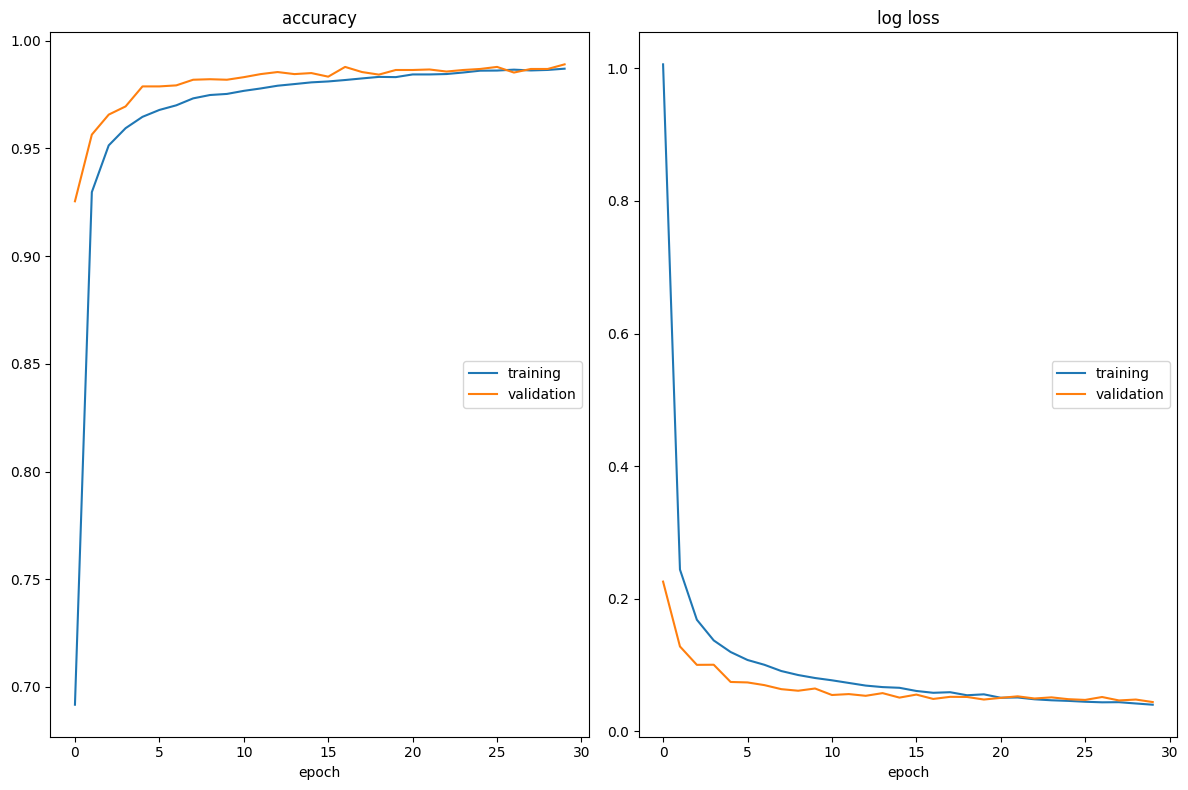

accuracy
	training         	 (min:    0.692, max:    0.987, cur:    0.987)
	validation       	 (min:    0.925, max:    0.989, cur:    0.989)
log loss
	training         	 (min:    0.040, max:    1.006, cur:    0.040)
	validation       	 (min:    0.044, max:    0.226, cur:    0.044)


In [15]:
def train_model(momentum):
  set_seed(seed)
  model = LeNet5drbn().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()

  train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(val_subset, batch_size=test_batch_size, shuffle=False, num_workers=0)
  test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return model

model = train_model(0.5)

### Use the evaluation function defined above to make predictions.

This method performs the same as validate but doesn't report losses, but simply returns all predictions on a given dataset (training, validation, test-set)

In [16]:
validation_loader = DataLoader(val_subset, batch_size=test_batch_size, shuffle=False, num_workers=0) # create a validation_loader
y_pred, y_gt = evaluate(model, validation_loader) # generate predictions and ground truths by evaluating the model

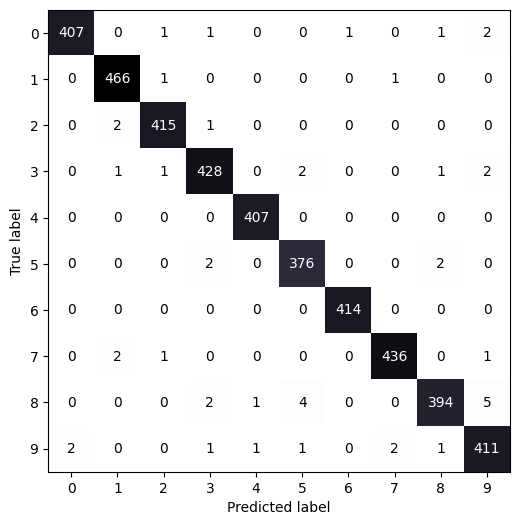

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_gt, y_pred, ax=ax, colorbar=False, cmap='bone_r')
plt.show()

Make prediction on test set and save it as a CSV

In [26]:
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0)

# Ensure the model is in evaluation mode
model.eval()

# List to store predictions
predictions = []

# No need to compute gradients (for efficiency)
with torch.no_grad():
    for images, _ in test_loader:  # Test loader doesn't have labels
        # Move images to the same device as your model
        images = images.to(device)  # device is "cuda" or "cpu"

        # Get model outputs
        outputs = model(images)

        # Convert outputs to predicted class (argmax)
        _, predicted = torch.max(outputs, 1)

        # Append predictions
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

# Save to CSV file
submission_df.to_csv('/content/gdrive/MyDrive/Dataset/digit-recognizer/sample.csv', index=False, header=True)


<br>

---

<br>

## 2. Training with data augmentation

Pytorch allows us to simply extend the available Datasets to more custom functionality. Here we provide an example of such a custom dataset class. You can see that there are 3 functions we need to implement:

- init(args, *kwargs): this will handle everything prior to actually using the dataset
- len(self): returns the length of the dataset i.e. the number of data items
- getitem(self, idx): this method takes an index of a specific data item and returns that item:
  - you can do whatever you want in these functions: apply transforms, normalize data, perform another computation, etc.
  - here we also have the functionality to apply a set of [torchvision.transforms](https://pytorch.org/tutorials/beginner/data_loading_tutorial.



### Transforms

Transforms can be used to perform manipulation of individual data prior to passing the data to our models.
This is useful for:
 - Data-augmentation i.e. creating slightly modified instance of the data we have while preserving their labels.
 - Data Preprocessing: Such as Normalization, Histogram Equalization
 - Transforming Targets: You may have complex labels that should change together with changes in the preprocessing of the images

 Pytorch and especially torchvision provides a [number of transforms](https://pytorch.org/docs/stable/torchvision/index.html) for you to use!
 A nice tutorial on custom dataloaders and transforms can be found [here](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

 The (probably) most state-of-the-art library for image augmentation is [albumentations](https://github.com/albu/albumentations) which has been successfully applied in winning kaggle competitions.


In [53]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Load the data
data_frame = pd.read_csv('/content/gdrive/MyDrive/Dataset/digit-recognizer/train.csv')
labels = data_frame.iloc[:, 0].values  # Assuming the first column is labels

# Split the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(sss.split(data_frame, labels))


In [57]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation, ToPILImage

# Define transformations without ToPILImage
train_transform = Compose([
    RandomRotation(10),
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]),
])

val_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.1307], std=[0.3081]),
])


# Create custom dataset class
class CustomMNISTDataset1(Dataset):
    def __init__(self, data_frame, indices, transform=None):
        self.data_frame = data_frame.iloc[indices]
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        label = self.data_frame.iloc[idx, 0]
        image = self.data_frame.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# Create dataset instances
train_dataset = CustomMNISTDataset1(data_frame, train_idx, transform=train_transform)
val_dataset = CustomMNISTDataset1(data_frame, val_idx, transform=val_transform)


### Training LeNet5 with data augmentation

In [58]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # new 2D convolutional layer
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
    self.c5 = nn.Linear(16*5*5, 120)                              # first linear layer
    self.f6 = nn.Linear(120, 84)                                  # second linear layer
    self.output = nn.Linear(84, 10)                               # final output layer
    self.act = nn.ReLU()                                          # activation function

  def forward(self, x):
    x = self.act(self.c1(x))                                      # activate pass through the first layer
    x = self.act(self.s2(x))                                      # activate pass through the second layer
    x = self.act(self.c3(x))                                      # activate pass through the third layer
    x = self.act(self.s4(x))                                      # activate pass through the fourth layer
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten (return a "flattened" view of the 3d tensor as inputs for the fully connected layer)
    x = self.act(self.c5(x))                                      # activate pass through fifth layer
    x = self.act(self.f6(x))                                      # activate pass through last layer
    return self.output(x)                                         # return output

x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)
print(model)

tensor([[-0.0231, -0.0212,  0.0957, -0.0879,  0.0479, -0.0213,  0.0135,  0.0183,
         -0.0573,  0.0908]], grad_fn=<AddmmBackward0>)
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


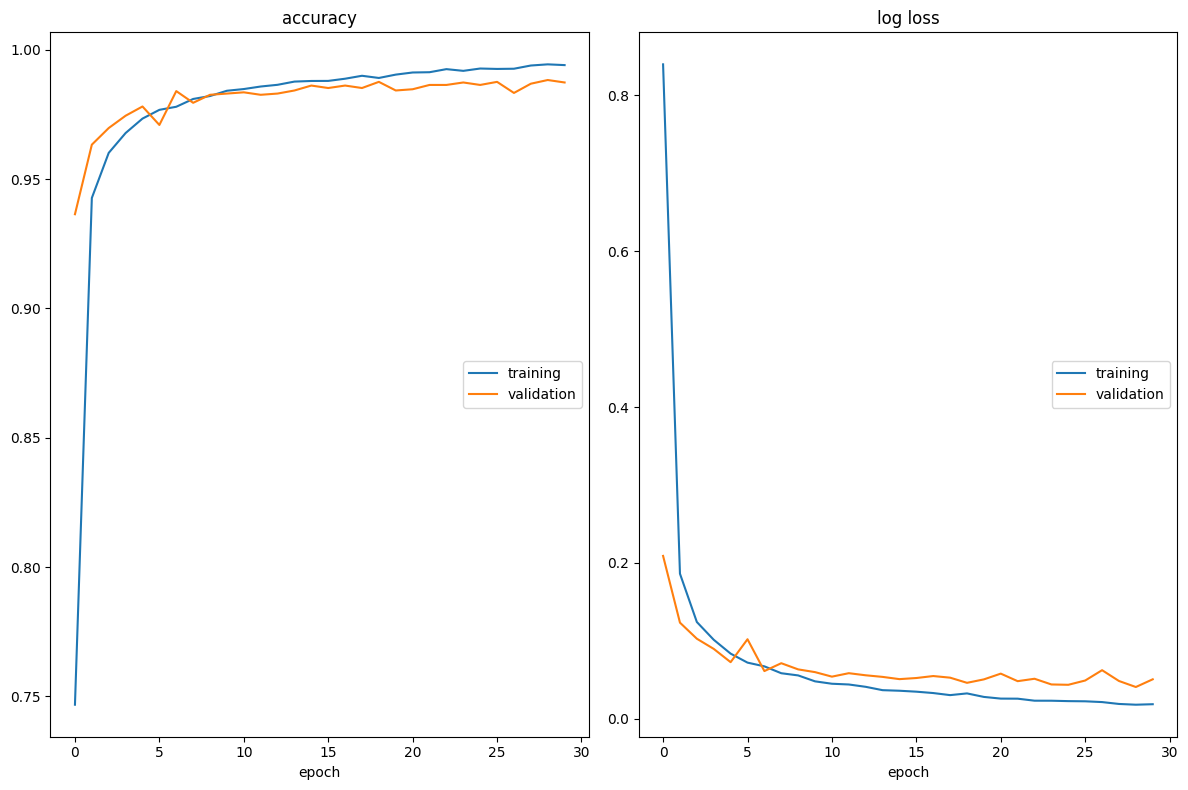

accuracy
	training         	 (min:    0.747, max:    0.994, cur:    0.994)
	validation       	 (min:    0.936, max:    0.988, cur:    0.987)
log loss
	training         	 (min:    0.018, max:    0.840, cur:    0.019)
	validation       	 (min:    0.041, max:    0.209, cur:    0.051)


In [59]:
def train_model_augmented(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return model

model = train_model_augmented(train_dataset, val_dataset)

In [60]:
validation_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0) # create a validation_loader
y_pred, y_gt = evaluate(model, validation_loader) # generate predictions and ground truths by evaluating the model

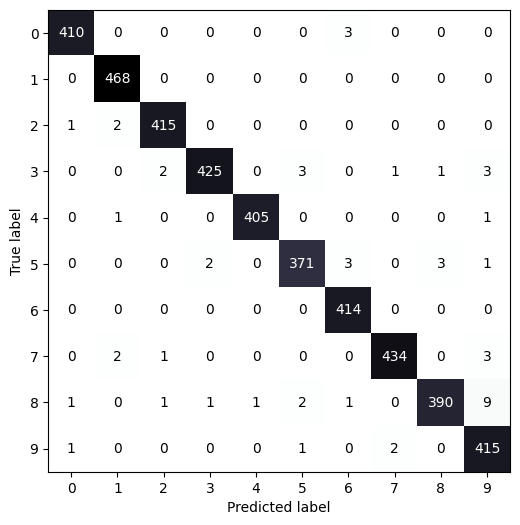

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_gt, y_pred, ax=ax, colorbar=False, cmap='bone_r')
plt.show()

In [63]:
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0)

# Ensure the model is in evaluation mode
model.eval()

# List to store predictions
predictions = []

# No need to compute gradients (for efficiency)
with torch.no_grad():
    for images, _ in test_loader:  # Test loader doesn't have labels
        # Move images to the same device as your model
        images = images.to(device)  # device is "cuda" or "cpu"

        # Get model outputs
        outputs = model(images)

        # Convert outputs to predicted class (argmax)
        _, predicted = torch.max(outputs, 1)

        # Append predictions
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

# Save to CSV file
submission_df.to_csv('/content/gdrive/MyDrive/Dataset/digit-recognizer/sample.csv', index=False, header=True)


<h2>Let's try and use and Improved version of LeNet5

In [64]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedLeNet5(nn.Module):
    def __init__(self):
        super(ImprovedLeNet5, self).__init__()
        self.c1 = nn.Conv2d(1, 12, kernel_size=5, stride=1, padding=2)  # Increased number of filters
        self.bn1 = nn.BatchNorm2d(12)                                   # Batch normalization
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(12, 32, kernel_size=5, stride=1)            # Increased number of filters
        self.bn2 = nn.BatchNorm2d(32)                                   # Batch normalization
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(32 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(0.5)                                 # Dropout
        self.f6 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)                                 # Dropout
        self.output = nn.Linear(84, 10)
        self.act = nn.ReLU()                                            # ReLU activation

    def forward(self, x):
        x = self.act(self.bn1(self.c1(x)))
        x = self.act(self.s2(x))
        x = self.act(self.bn2(self.c3(x)))
        x = self.act(self.s4(x))
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = self.act(self.dropout1(self.c5(x)))
        x = self.act(self.dropout2(self.f6(x)))
        return self.output(x)


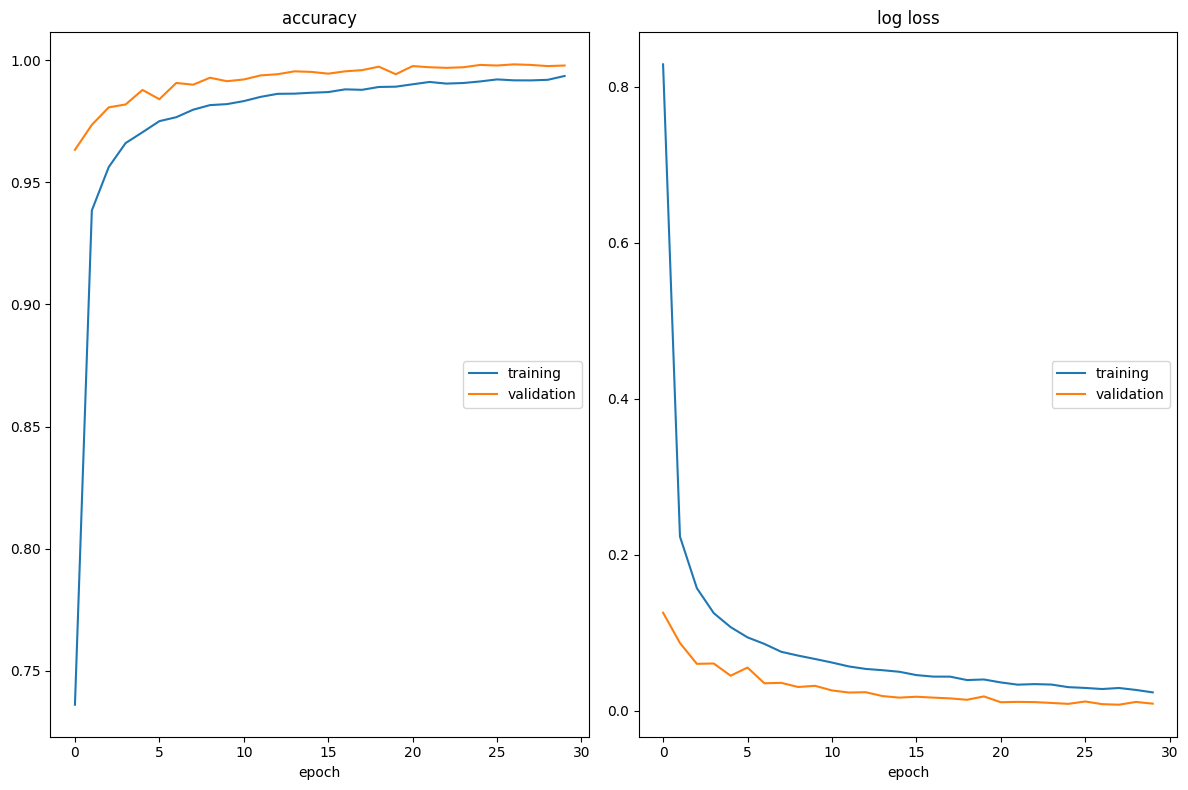

accuracy
	training         	 (min:    0.736, max:    0.994, cur:    0.994)
	validation       	 (min:    0.963, max:    0.998, cur:    0.998)
log loss
	training         	 (min:    0.023, max:    0.829, cur:    0.023)
	validation       	 (min:    0.008, max:    0.126, cur:    0.009)


In [65]:
def train_model_augmented(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = ImprovedLeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return model

model = train_model_augmented(train_dataset, val_dataset)

In [66]:
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0)

# Ensure the model is in evaluation mode
model.eval()

# List to store predictions
predictions = []

# No need to compute gradients (for efficiency)
with torch.no_grad():
    for images, _ in test_loader:  # Test loader doesn't have labels
        # Move images to the same device as your model
        images = images.to(device)  # device is "cuda" or "cpu"

        # Get model outputs
        outputs = model(images)

        # Convert outputs to predicted class (argmax)
        _, predicted = torch.max(outputs, 1)

        # Append predictions
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

# Save to CSV file
submission_df.to_csv('/content/gdrive/MyDrive/Dataset/digit-recognizer/sample.csv', index=False, header=True)


**Score: 0.98967**

In [67]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedLeNet5(nn.Module):
    def __init__(self):
        super(ImprovedLeNet5, self).__init__()
        self.c1 = nn.Conv2d(1, 12, kernel_size=5, stride=1, padding=2)  # Increased number of filters
        self.bn1 = nn.BatchNorm2d(12)                                   # Batch normalization
        self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(12, 32, kernel_size=5, stride=1)            # Increased number of filters
        self.bn2 = nn.BatchNorm2d(32)                                   # Batch normalization
        self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Linear(32 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(0.5)                                 # Dropout
        self.f6 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)                                 # Dropout
        self.output = nn.Linear(84, 10)
        self.act = nn.LeakyReLU()                                            # ReLU activation

    def forward(self, x):
        x = self.act(self.bn1(self.c1(x)))
        x = self.act(self.s2(x))
        x = self.act(self.bn2(self.c3(x)))
        x = self.act(self.s4(x))
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = self.act(self.dropout1(self.c5(x)))
        x = self.act(self.dropout2(self.f6(x)))
        return self.output(x)


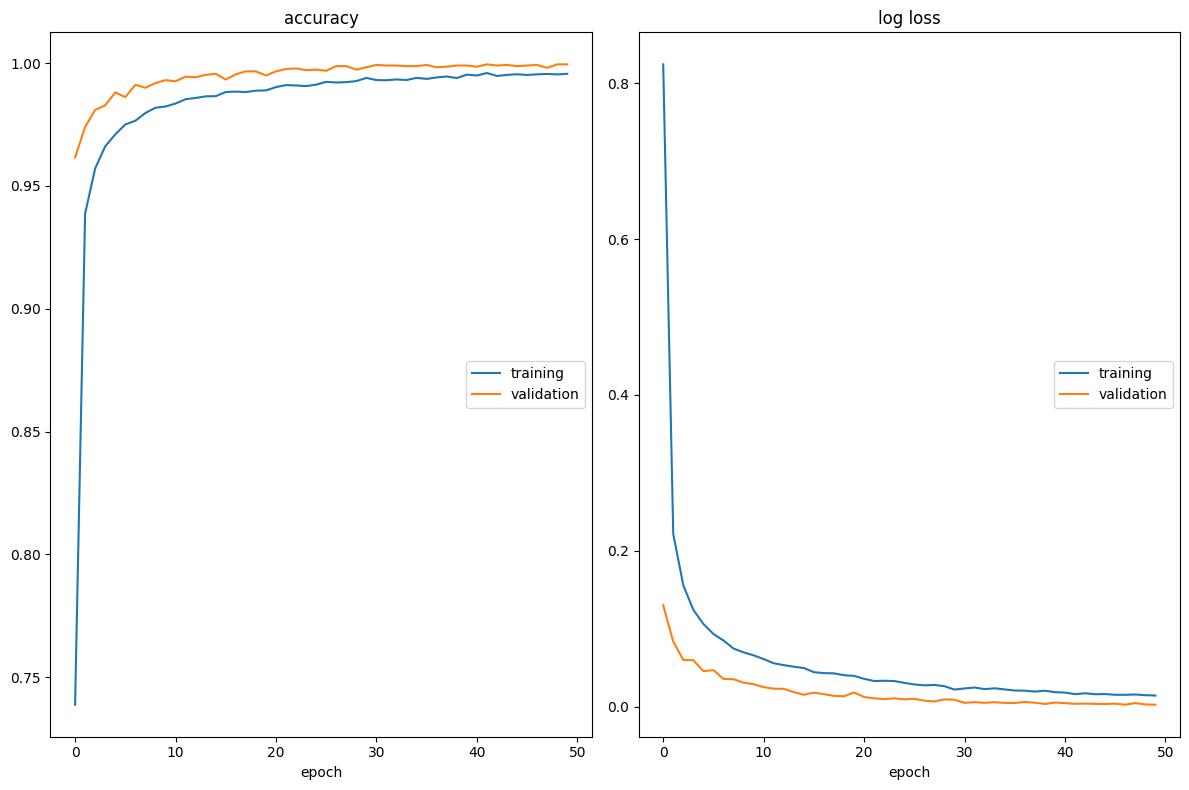

accuracy
	training         	 (min:    0.739, max:    0.996, cur:    0.996)
	validation       	 (min:    0.962, max:    1.000, cur:    1.000)
log loss
	training         	 (min:    0.014, max:    0.824, cur:    0.014)
	validation       	 (min:    0.002, max:    0.130, cur:    0.002)


In [70]:
def train_model_augmented(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = ImprovedLeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(50):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return model

model = train_model_augmented(train_dataset, val_dataset)

In [71]:
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0)

# Ensure the model is in evaluation mode
model.eval()

# List to store predictions
predictions = []

# No need to compute gradients (for efficiency)
with torch.no_grad():
    for images, _ in test_loader:  # Test loader doesn't have labels
        # Move images to the same device as your model
        images = images.to(device)  # device is "cuda" or "cpu"

        # Get model outputs
        outputs = model(images)

        # Convert outputs to predicted class (argmax)
        _, predicted = torch.max(outputs, 1)

        # Append predictions
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

# Save to CSV file
submission_df.to_csv('/content/gdrive/MyDrive/Dataset/digit-recognizer/sample.csv', index=False, header=True)


**Score: 0.991**

In [79]:
import torch.nn as nn
import torch.nn.functional as F

class AdvancedLeNet5(nn.Module):
    def __init__(self):
        super(AdvancedLeNet5, self).__init__()
        # Convolutional layers
        self.c1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Smaller filter size, more filters
        self.bn1 = nn.BatchNorm2d(16)
        self.c2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.c3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 120)  # Adjusted for 3 conv layers
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(84, 10)  # Output layer

        # Activation function
        self.act = nn.LeakyReLU()

    def forward(self, x):
        # Applying conv layers, batch norm, activation, and pooling
        x = self.pool(self.act(self.bn1(self.c1(x))))
        x = self.pool(self.act(self.bn2(self.c2(x))))
        x = self.act(self.bn3(self.c3(x)))

        # Flattening the output for the fully connected layers
        x = x.view(-1, 64 * 7 * 7)

        # Fully connected layers with dropout
        x = self.act(self.dropout1(self.fc1(x)))
        x = self.act(self.dropout2(self.fc2(x)))
        x = self.fc3(x)  # No activation and no dropout on output layer

        return x


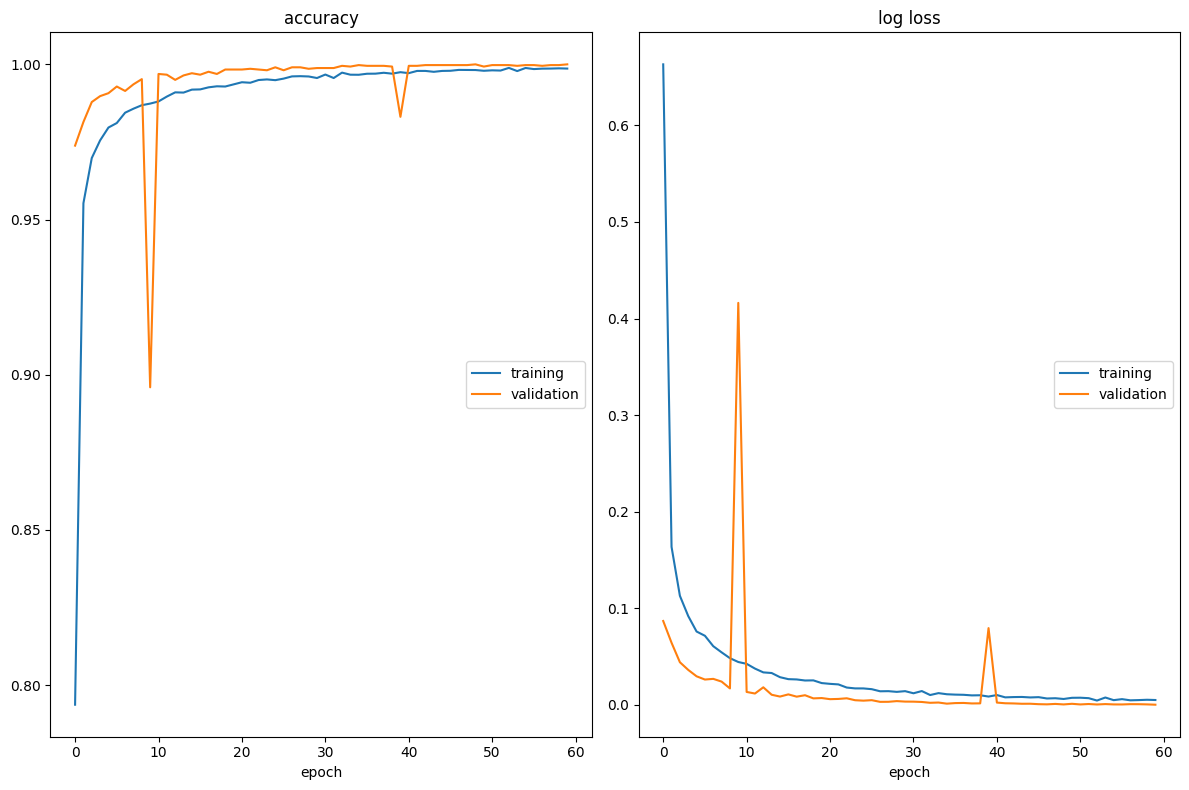

accuracy
	training         	 (min:    0.794, max:    0.999, cur:    0.999)
	validation       	 (min:    0.896, max:    1.000, cur:    1.000)
log loss
	training         	 (min:    0.005, max:    0.663, cur:    0.005)
	validation       	 (min:    0.000, max:    0.416, cur:    0.000)


In [80]:
def train_model_augmented(train_dataset, validation_dataset, momentum=0.5):
  set_seed(seed)
  model = AdvancedLeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(validation_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(60):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return model

model = train_model_augmented(train_dataset, val_dataset)

In [81]:
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=0)

# Ensure the model is in evaluation mode
model.eval()

# List to store predictions
predictions = []

# No need to compute gradients (for efficiency)
with torch.no_grad():
    for images, _ in test_loader:  # Test loader doesn't have labels
        # Move images to the same device as your model
        images = images.to(device)  # device is "cuda" or "cpu"

        # Get model outputs
        outputs = model(images)

        # Convert outputs to predicted class (argmax)
        _, predicted = torch.max(outputs, 1)

        # Append predictions
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

# Save to CSV file
submission_df.to_csv('/content/gdrive/MyDrive/Dataset/digit-recognizer/sample.csv', index=False, header=True)


**Score: 0.99153**